# Understanding DCT

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from skimage.util import img_as_ubyte
import matplotlib.image as mpimg

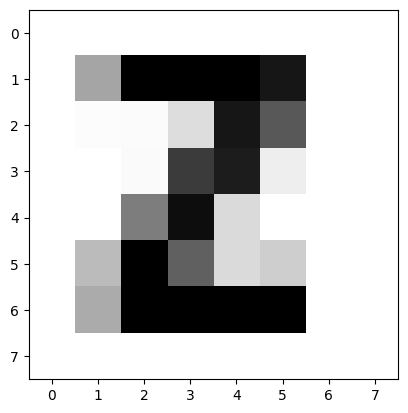

In [3]:
# loading a simple Z character image (8x8)
img = img_as_ubyte(mpimg.imread('img/z_char_8x8.png'))
img_h = 8
gray_img = img[:,:,0]

plt.imshow(img, cmap='gray', interpolation='nearest')

# Pixel Values

In [4]:
np.set_printoptions(precision=1, linewidth=140, suppress=True)
gray_img

array([[255, 255, 255, 255, 255, 255, 255, 255],
       [255, 165,   0,   0,   0,  22, 255, 255],
       [255, 252, 251, 221,  22,  88, 255, 255],
       [255, 255, 250,  59,  28, 238, 255, 255],
       [255, 255, 125,  13, 218, 255, 255, 255],
       [255, 187,   0,  96, 218, 206, 255, 255],
       [255, 171,   0,   0,   0,   0, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255]], dtype=uint8)

# Coefficient Values

In [5]:
z_dct = fftpack.dct(fftpack.dct(gray_img.T, norm='ortho').T, norm='ortho')

np.set_printoptions(precision=1, linewidth=140, suppress=True)
z_dct

array([[1533.1,  -57.3,  450.2,   49.7,  -39.4,   21.9,  -77.6,   14. ],
       [  13.6,   47.2,    7.7,  -85.3,  -37.5,   49.5,   25.4,  -14.8],
       [  59.4,   14.5,  -98.6,  -45. ,   94.5,   42.7,  -46.3,   -2.4],
       [ -19. ,  -95.4,  -21.9,  172. ,   71.9,  -98.6,  -44.8,   27.3],
       [ 293.4,   22.1, -200.3,   25.4,  -98.1,  -81.2,  122.9,   11.7],
       [  -3.7,   45.9,   23.6,  -88.7,  -43.5,   59.6,   30.2,  -22.1],
       [ 251. ,   30.1, -223.6,  -30.1,   25.9,    6.6,   28.1,  -41.6],
       [  23.3,   38.6,  -12.8,  -51.8,    5.7,    2.1,  -22.9,   20.7]])

# DCT basis

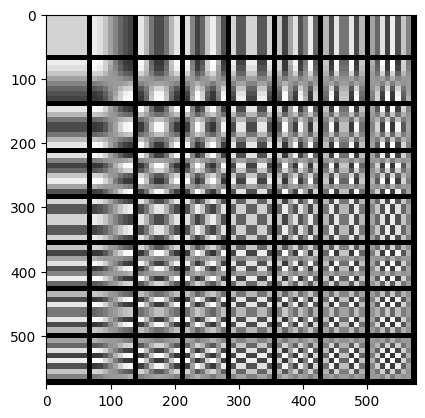

In [6]:
dct_basis = img_as_ubyte(mpimg.imread('img/dct_basis.png'))
plt.imshow(dct_basis, cmap='gray', interpolation='nearest')

# Reconstructed imgs

In [8]:
partial_z_idct = []
partial_z_dct = []

for ii in range(img_h*img_h):
    dct_copy = np.copy(z_dct)
    frequency_counter = 0 
    
    for u in range(img_h):
        for v in range(img_h):
            if frequency_counter > ii:
                dct_copy[u,v] = 0
            frequency_counter += 1
            
    partial_z_dct.append(dct_copy)
    
    partial_img_idct = fftpack.idct(fftpack.idct(dct_copy.T, norm='ortho').T, norm='ortho')
    partial_z_idct.append(partial_img_idct)

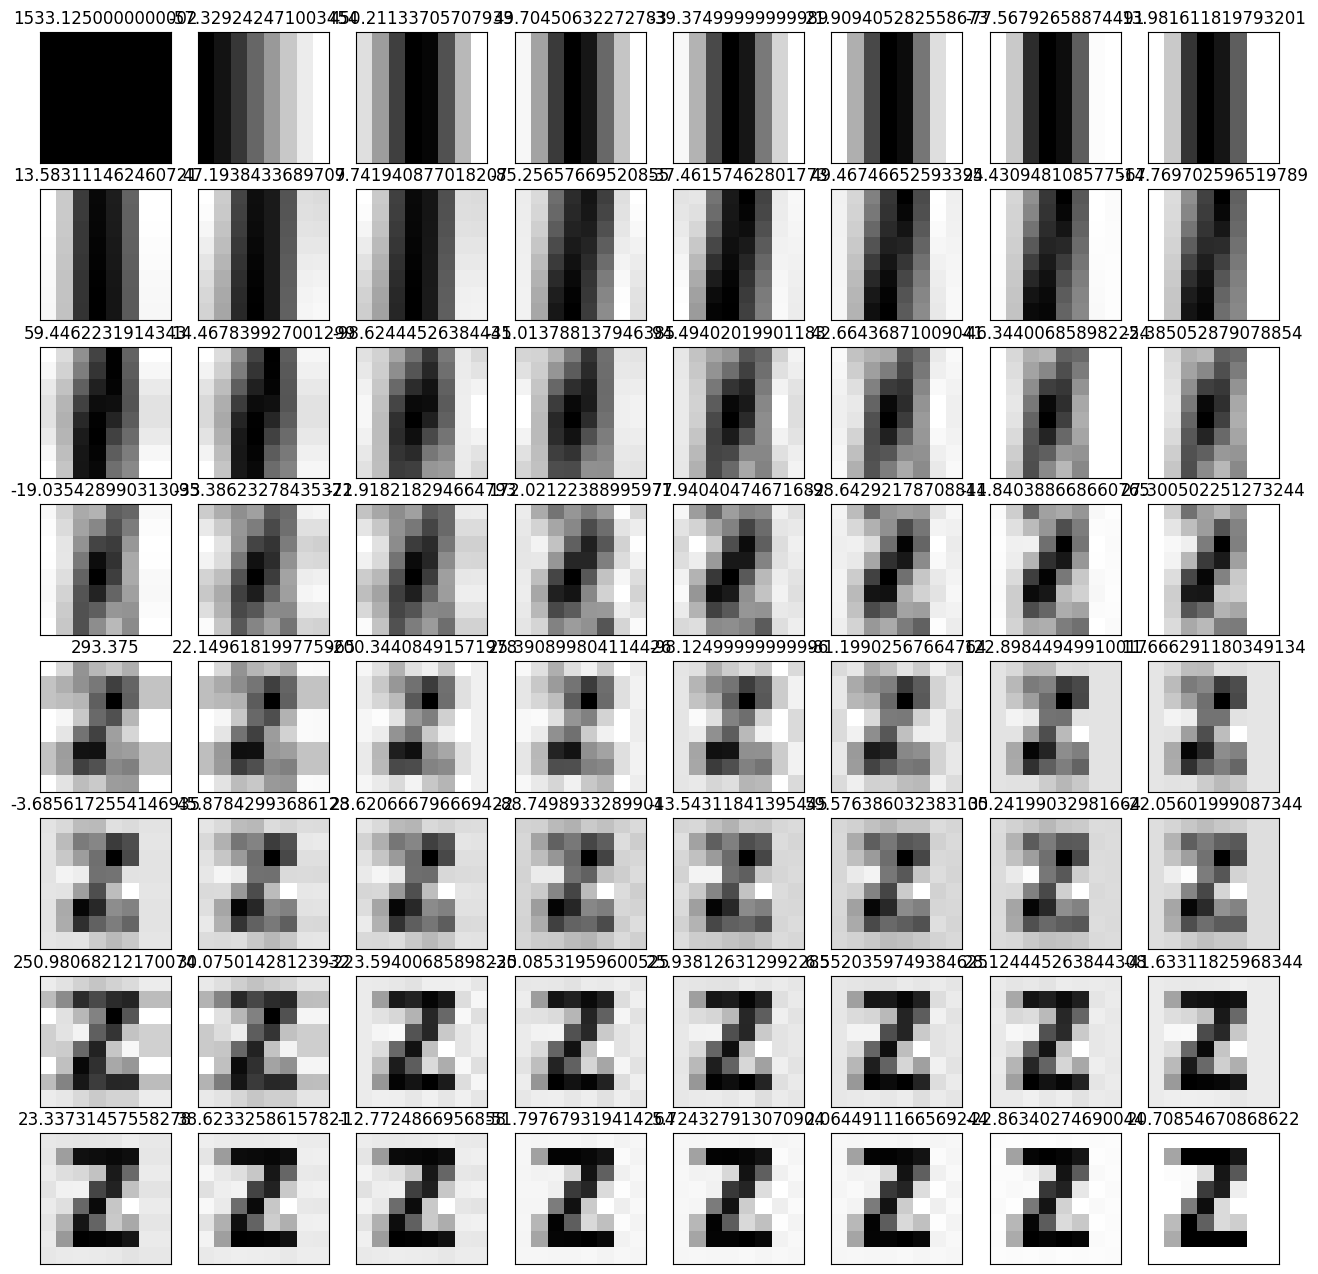

In [9]:
# shows each coefficient evolution towards the image formation
# here you can see how each DCT basis constributes to the image formation
# try to visualize them as a summation of the basis throughout the 64 elements 
fig = plt.figure(figsize=(16, 16))
for ii in range(img_h*img_h):
    plt.subplot(8, 8, ii + 1)
    plt.title(partial_z_dct[ii][int(ii / 8), ii % 8])
    plt.imshow(partial_z_idct[ii], cmap='gray', interpolation='nearest')
    plt.grid(False);
    plt.xticks([]);
    plt.yticks([]);

### zigzag로 상위 10개 DCT coefficient로 reconstruction

In [11]:
def create_zigzag_order(n):
    """
    n x n 행렬에 대한 지그재그 순서를 생성
    Returns: 지그재그 순서대로 (u, v) 좌표 리스트
    """
    zigzag_order = []
    
    # 대각선별로 처리
    for diagonal in range(2 * n - 1):
        coords = []
        
        # 각 대각선에서 가능한 좌표들 찾기
        for u in range(n):
            v = diagonal - u
            if 0 <= v < n:
                coords.append((u, v))
        
        # 짝수 대각선은 위에서 아래로, 홀수 대각선은 아래에서 위로
        if diagonal % 2 == 0:
            coords.reverse()
        
        zigzag_order.extend(coords)
    
    return zigzag_order

def reconstruct_with_top_k_coefficients(dct_coeffs, k):
    """
    지그재그 순서로 상위 k개 계수만 사용하여 이미지 재구성
    """
    n = dct_coeffs.shape[0]
    zigzag_order = create_zigzag_order(n)
    
    # 모든 계수를 0으로 초기화
    reconstructed_dct = np.zeros_like(dct_coeffs)
    
    # 지그재그 순서로 상위 k개 계수만 복사
    for i in range(min(k, len(zigzag_order))):
        u, v = zigzag_order[i]
        reconstructed_dct[u, v] = dct_coeffs[u, v]
    
    # 역 DCT 변환
    reconstructed_img = fftpack.idct(fftpack.idct(reconstructed_dct.T, norm='ortho').T, norm='ortho')
    
    return reconstructed_img, reconstructed_dct

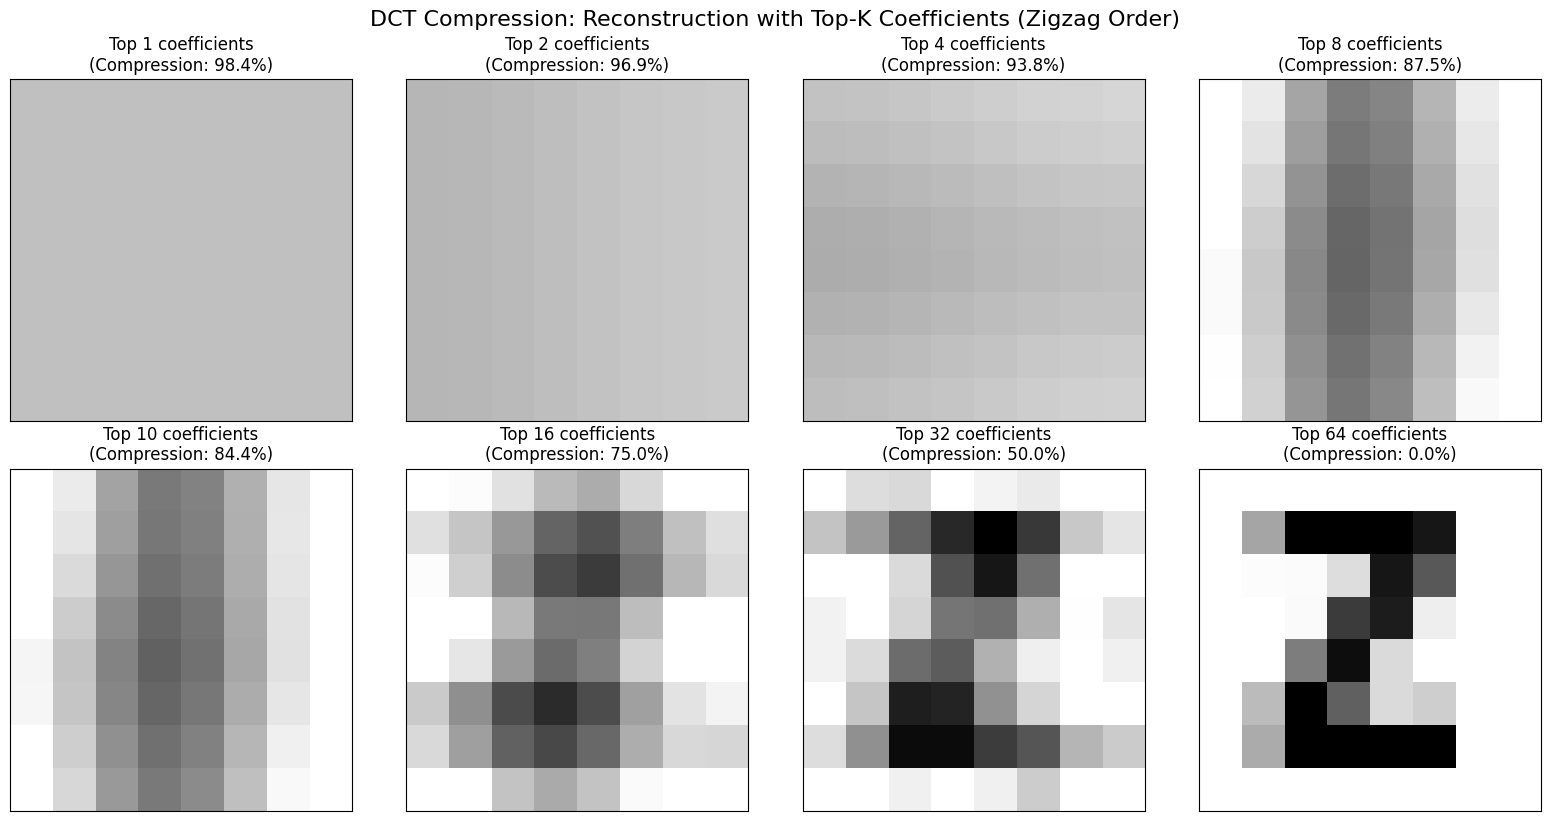

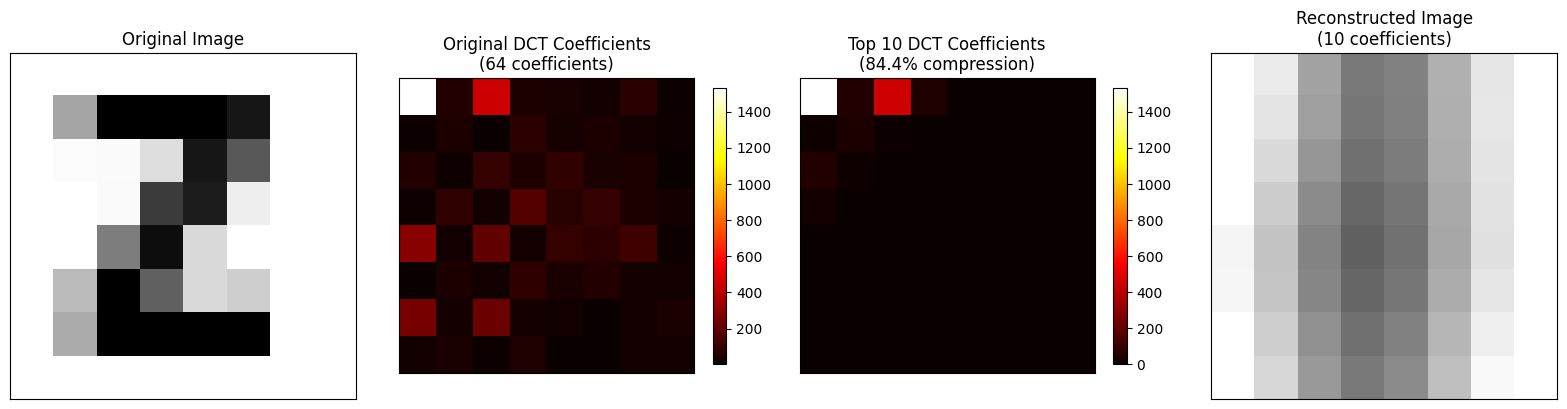

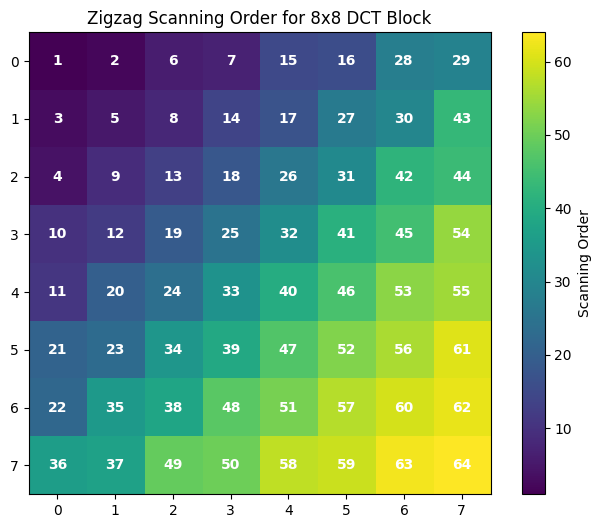

Compression Analysis:
Original image: 64 coefficients (0% compression)
Reconstructed with 10 coefficients: 84.4% compression
MSE: 6278.50
PSNR: 10.15 dB
Data reduction: 54 coefficients removed out of 64

Top 10 DCT coefficients (in zigzag order):
Position (0,0): 1533.1
Position (0,1): -57.3
Position (1,0): 13.6
Position (2,0): 59.4
Position (1,1): 47.2
Position (0,2): 450.2
Position (0,3): 49.7
Position (1,2): 7.7
Position (2,1): 14.5
Position (3,0): -19.0


In [12]:
# 다양한 계수 개수로 재구성 비교
k_values = [1, 2, 4, 8, 10, 16, 32, 64]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    reconstructed_img, reconstructed_dct = reconstruct_with_top_k_coefficients(z_dct, k)
    
    # 이미지 출력
    axes[idx].imshow(reconstructed_img, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
    axes[idx].set_title(f'Top {k} coefficients\n(Compression: {100*(64-k)/64:.1f}%)')
    axes[idx].grid(False)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

plt.tight_layout()
plt.suptitle('DCT Compression: Reconstruction with Top-K Coefficients (Zigzag Order)', 
             fontsize=16, y=1.02)
plt.show()

# 원본과 상위 10개 계수로 재구성한 이미지 비교
reconstructed_10, dct_10 = reconstruct_with_top_k_coefficients(z_dct, 10)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# 원본 이미지
axes[0].imshow(gray_img, cmap='gray', interpolation='nearest')
axes[0].set_title('Original Image')
axes[0].grid(False); axes[0].set_xticks([]); axes[0].set_yticks([])

# 원본 DCT 계수
im1 = axes[1].imshow(np.abs(z_dct), cmap='hot', interpolation='nearest')
axes[1].set_title('Original DCT Coefficients\n(64 coefficients)')
axes[1].grid(False); axes[1].set_xticks([]); axes[1].set_yticks([])
plt.colorbar(im1, ax=axes[1], shrink=0.8)

# 상위 10개 DCT 계수
im2 = axes[2].imshow(np.abs(dct_10), cmap='hot', interpolation='nearest')
axes[2].set_title('Top 10 DCT Coefficients\n(84.4% compression)')
axes[2].grid(False); axes[2].set_xticks([]); axes[2].set_yticks([])
plt.colorbar(im2, ax=axes[2], shrink=0.8)

# 재구성된 이미지
axes[3].imshow(reconstructed_10, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
axes[3].set_title('Reconstructed Image\n(10 coefficients)')
axes[3].grid(False); axes[3].set_xticks([]); axes[3].set_yticks([])

plt.tight_layout()
plt.show()

# 지그재그 순서 시각화
zigzag_order = create_zigzag_order(8)
zigzag_matrix = np.zeros((8, 8))

for idx, (u, v) in enumerate(zigzag_order):
    zigzag_matrix[u, v] = idx + 1

plt.figure(figsize=(8, 6))
plt.imshow(zigzag_matrix, cmap='viridis', interpolation='nearest')
plt.title('Zigzag Scanning Order for 8x8 DCT Block')
plt.colorbar(label='Scanning Order')

# 숫자 표시
for u in range(8):
    for v in range(8):
        plt.text(v, u, f'{int(zigzag_matrix[u, v])}', 
                ha='center', va='center', color='white', fontweight='bold')

plt.grid(False)
plt.show()

# 압축 효율성 분석
print("Compression Analysis:")
print("=" * 50)
original_mse = 0  # 원본과 원본의 MSE는 0
mse_10 = np.mean((gray_img - reconstructed_10) ** 2)
psnr_10 = 10 * np.log10(255**2 / mse_10) if mse_10 > 0 else float('inf')

print(f"Original image: 64 coefficients (0% compression)")
print(f"Reconstructed with 10 coefficients: 84.4% compression")
print(f"MSE: {mse_10:.2f}")
print(f"PSNR: {psnr_10:.2f} dB")
print(f"Data reduction: {64-10} coefficients removed out of 64")

# 중요한 계수들의 값 출력
print(f"\nTop 10 DCT coefficients (in zigzag order):")
for i in range(10):
    u, v = zigzag_order[i]
    print(f"Position ({u},{v}): {z_dct[u,v]:.1f}")